In [1]:
from single_cell_model_hh2 import SingleCellCalciumModelHH2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.integrate import odeint
from fluorescence_encoder import FluorescenceEncoder

In [2]:
T = 20
dt = 0.001

In [3]:
class CellChainCalciumModel(SingleCellCalciumModelHH2):
    def __init__(self, num):
        super().__init__()
        self.num = num
        self.gc = 500
        onex = np.ones(self.num)
        oney = np.ones(self.num)
        
        self.Dx = spdiags(np.array([onex,-2*onex,onex]),\
        np.array([-1,0,1]),self.num,self.num).toarray()
        
        self.Dx[0,0] = -1
        self.Dx[self.num-1,self.num-1] = -1 
        self.time = np.linspace(0, T, int(T/dt))
    
    # Override
    def rhs(self, y, t):
        
        c, c_t, hh, ip, v, m, h, n, m_cal, h_cal = y[0:self.num], \
        y[self.num:2*self.num], y[2*self.num:3*self.num], \
        y[3*self.num:4*self.num], y[4*self.num:5*self.num], \
        y[5*self.num:6*self.num], y[6*self.num:7*self.num], \
        y[7*self.num:8*self.num], y[8*self.num:9*self.num], \
        y[9*self.num:10*self.num]
    
        dcdt = (self.i_ip3r(c, c_t, hh, ip) \
             - self.i_serca(c) \
             + self.i_leak(c, c_t)) \
             + (- self.i_pmca(c) \
                - self.i_cal(v, m_cal, h_cal) \
                + self.i_soc(c, c_t) \
                - self.i_out(c)) * self.delta
        
        dctdt = (- self.i_pmca(c) - self.i_cal(v, m_cal, h_cal) + self.i_soc(c, c_t) - self.i_out(c))\
                 * self.delta

        dhhdt = (self.hh_inf(c, ip) - hh) / self.tau_hh(c, ip)

        dipdt = np.zeros(self.num)
        
        dvdt = - (self.i_na(v,m,h) \
                  + self.i_k(v,n) \
                  + self.i_bk(v) \
                  + 2*self.i_cal(v, m_cal, h_cal))/self.c_m\
               + self.gc * self.Dx@v
        
        dvdt[0:3] += self.stim(t)/self.c_m
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n
        dmcaldt = (self.m_cal_inf(v) - m_cal) / self.tau_cal_m(v)
        dhcaldt = (self.h_cal_inf(v) - h_cal) / self.tau_cal_h(v)
        
        deriv = np.array([dcdt, dctdt, \
                          dhhdt, dipdt, dvdt, dmdt, dhdt, dndt, dmcaldt, dhcaldt])
        
        dydt = np.reshape(deriv, 10*self.num)  
        
        return dydt
    
    # Override
    def step(self):
        self.hh0 = self.hh_inf(self.c0, self.ip0)
        
        y0 = np.array([[self.c0]*self.num, \
                       [self.ct0]*self.num, \
                       [self.hh0]*self.num, \
                       [self.ip0]*self.num, \
                       [self.v0]*self.num, \
                       [self.m0]*self.num, \
                       [self.h0]*self.num, \
                       [self.n0]*self.num, \
                       [self.m_cal0]*self.num, \
                       [self.h_cal0]*self.num])
        y0 = np.reshape(y0, 10*self.num)
        
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol
    
    # Plot
    def plot(self, a, tmin=0, tmax=-1):
        
        plt.figure(figsize=(7,4))
        plt.plot(self.time[int(tmin/dt):int(tmax/dt)], a[int(tmin/dt):int(tmax/dt)])
        plt.show()

In [14]:
if __name__ == '__main__':
    
    n_cel = 100
    
    model = CellChainCalciumModel(n_cel)
    sol = model.step()
    c = sol[:, 0:n_cel]
    c_t = sol[:, n_cel:2*n_cel]
    hh = sol[:, 2*n_cel:3*n_cel]
    ip = sol[:, 3*n_cel:4*n_cel]
    v = sol[:, 4*n_cel:5*n_cel]

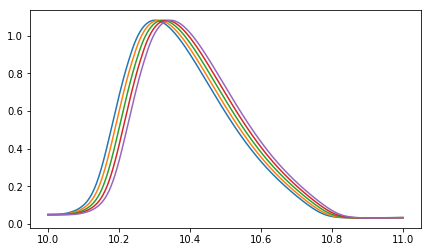

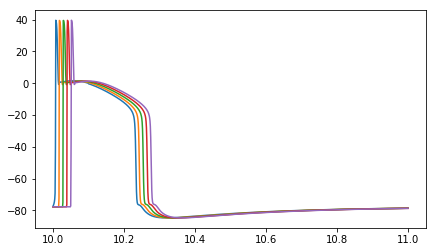

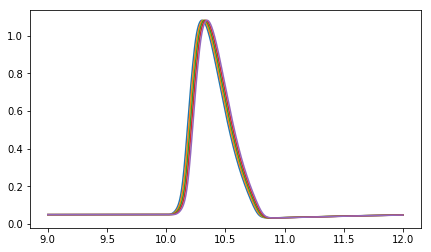

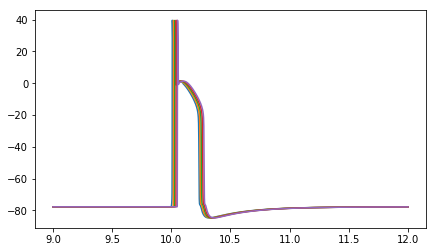

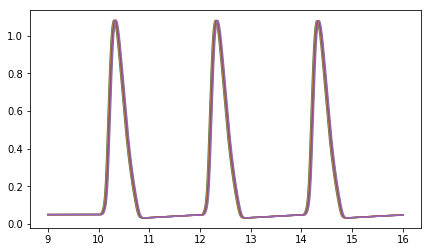

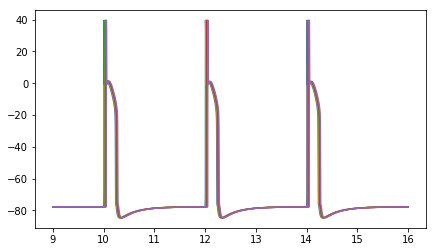

In [15]:
model.plot(c[:, ::20], 10, 11)
model.plot(v[:, ::20], 10, 11)
model.plot(c[:, ::20], 9, 12)
model.plot(v[:, ::20], 9, 12)
model.plot(c[:, ::20], 9, 16)
model.plot(v[:, ::20], 9, 16)

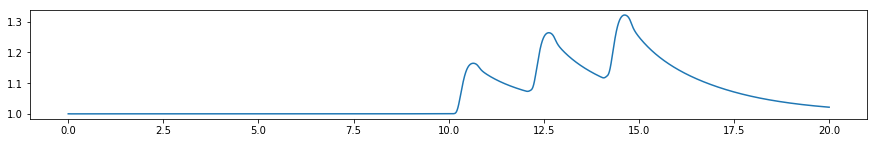

In [16]:
plt.figure(figsize = (15,2))
plt.plot(model.time, FluorescenceEncoder(c[:,0], T, dt).step())
plt.show()